In [152]:
from pathlib import Path

import pandas as pd
import numpy as np
import preliz as pz
import pymc as pm
from scipy.stats import truncnorm

import arviz as az
import matplotlib.pyplot as pp
import seaborn as sb

### General polynomial form for all OCx models:

$$
\log_{10}(Chl_a) = a_0 + a_1 X + a_2 X^2 + a_3 X^3 + a_4 X^4
$$

OC4_SEAWIFS
$$
X = \log_{10} \left( \frac{\max \left( R_{rs,443},\ R_{rs,490},\ R_{rs,510} \right)}{R_{rs,555}} \right)
$$

OC5_SEAWIFS
$$
X = \log_{10} \left( \frac{\max \left( R_{rs,412},\ R_{rs,443},\ R_{rs,490},\ R_{rs,510} \right)}{R_{rs,555}} \right)
$$

OC6_SEAWIFS
$$
X = \log_{10} \left( \frac{\max \left( R_{rs,412},\ R_{rs,443},\ R_{rs,490},\ R_{rs,510} \right)}{\frac{R_{rs,555} + R_{rs,670}}{2}} \right)
$$


From table 6 of Oreilly et al. 2019:

| Coefficient |   OC4_SEAWIFS  |   OC5_SEAWIFS  |   OC6_SEAWIFS  |
|------------:|---------------:|---------------:|---------------:|
| a₀          |       0.32814  |       0.33899  |       0.92160  |
| a₁          |      -3.20725  |      -3.11338  |      -3.17884  |
| a₂          |       3.22969  |       3.35701  |       2.39690  |
| a₃          |      -1.36769  |      -2.01792  |      -1.30318  |
| a₄          |      -0.81739  |      -0.03811  |       0.20160  |


### Mocking MBR and Chlorophyll

#### Step 1: Understand the Empirical Relationship Between MBR and Chlorophyll
From O'Reilly et al. (2019) and historical band-ratio algorithms:

Low chlorophyll → high MBR
(blue reflectance strong relative to green + red → clear waters)

High chlorophyll → low MBR
(blue reflectance absorbed, green/red dominates → turbid waters)


#### Step 2 Mock MBR
Thus:

MBR values between 0.3 and 30 (raw)

Corresponding $log_{10}(MBR)$ from roughly -0.5 to 1.5

But not uniform:
More observations cluster around moderate to high MBR (open ocean dominates).

In [195]:
# Assume mean somewhere around 0.75 (MBR ~ 5.6), std dev ~0.5
mbr_mean = 0.75
mbr_std = 0.5
lower, upper = -0.5, 1.5  # bounds for log10(MBR)

# Create a truncated normal
a, b = (lower - mbr_mean) / mbr_std, (upper - mbr_mean) / mbr_std
log_mbr_mock = truncnorm.rvs(a, b, loc=mbr_mean, scale=mbr_std, size=500)

#### Step 3: Mocking Chl 


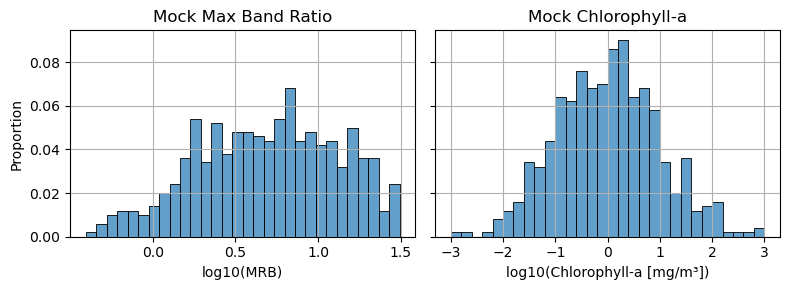

In [214]:
# Simulate mock log10(Chl_a) data
np.random.seed(42)  # for reproducibility
log_chl_mock = np.random.normal(loc=0.0, scale=1.0, size=500)

# Clip to [-3, 3] to match the desired support
log_chl_mock = np.clip(log_chl_mock, -3, 3)

# Transform back to raw Chl-a if needed
chl_mock = 10**log_chl_mock
histplot_args = dict(bins=30, edgecolor='k', alpha=0.7, stat='proportion')
# Plot
f, ax = pp.subplots(ncols=2, figsize=(8, 3), sharey=True)
sb.histplot(log_mbr_mock, ax=ax[0], **histplot_args)
ax[0].set_xlabel('log10(MRB)')
ax[0].set_title('Mock Max Band Ratio')
ax[0].grid(True)
sb.histplot(log_chl_mock, ax=ax[1], **histplot_args)
ax[1].set_xlabel('log10(Chlorophyll-a [mg/m³])')
ax[1].set_title('Mock Chlorophyll-a')
ax[1].grid(True)
f.tight_layout()
f.savefig('./manuscript/images/mock_data_dist.png', dpi=300)
f.savefig('./manuscript/images/mock_data_dist.pdf', dpi=300)


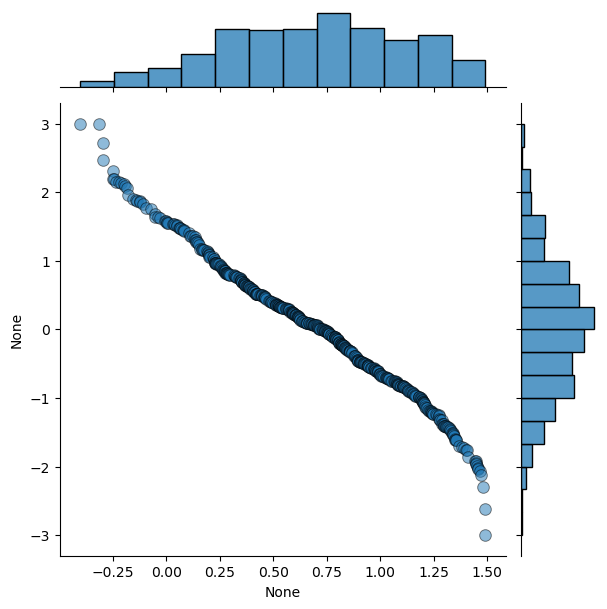

In [204]:
g = sb.jointplot(x=np.sort(log_mbr_mock), y=np.sort(log_chl_mock)[::-1], s=70, edgecolor='k', alpha=0.5)

In [ ]:
def poly_mbr_prior_model(
    log10_mbr, log10_chl,
    a0_μ=0, a0_σ=1, a1_μ=0, a1_σ=1,a2_μ=0, a2_σ=1, 
    a3_μ=0, a3_σ=1, a4_μ=0, a4_σ=1, σ_scale=1.0, 
    log_chl_lower=-3, log_chl_upper=3):
    
    x = log10_mbr
    with pm.Model() as model:
        # Priors on polynomial coefficients
        a0 = pm.Normal("a0", mu=a0_μ, sigma=a0_σ)
        a1 = pm.Normal("a1", mu=a1_μ, sigma=a1_σ)
        a2 = pm.Normal("a2", mu=a2_μ, sigma=a2_σ)
        a3 = pm.Normal("a3", mu=a3_μ, sigma=a3_σ)
        a4 = pm.Normal("a4", mu=a4_μ, sigma=a4_σ)

        # Prior on noise scale (allows exploration of model spread)
        σ = pm.Exponential("σ", 1.0 / σ_scale)

        # Generative model
        μ = a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4

        # Fake observations (0s just to build a model with shape)
        #log_chl_a = pm.Normal("log_chl_a", mu=μ, sigma=σ, observed=np.log10(y))
        log_chl_a = pm.TruncatedNormal(
            'log_chl_a', mu=μ, sigma=σ, lower=log_chl_lower, upper=log_chl_upper, observed=log10_chl)

    return model

In [209]:
# This is a cell meant to experiment with the priors.
payload = dict(
    a0_μ=0, a0_σ=1, a1_μ=0, a1_σ=1, a2_μ=0, a2_σ=1, 
    a3_μ=0, a3_σ=1, a4_μ=0, a4_σ=1, σ_scale=5.0
)
model_oc6 = poly_mbr_prior_model(log_mbr_mock, log_chl_mock, **payload)
with model_oc6:
    idata_oc6 = pm.sample_prior_predictive()


Sampling: [a0, a1, a2, a3, a4, log_chl_a, σ]


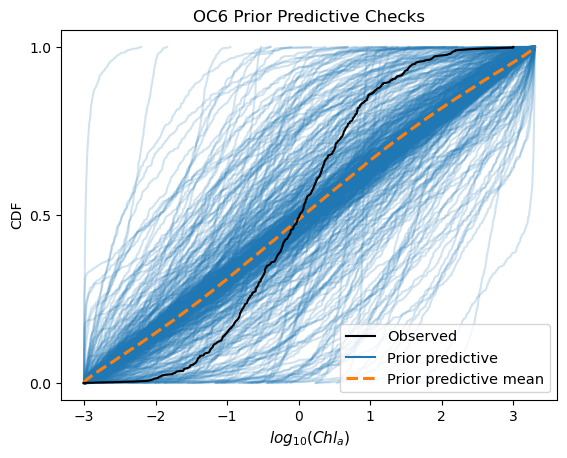

In [213]:
f, ax = pp.subplots()
az.plot_ppc(idata_oc6, group='prior', kind='cumulative', observed=True, ax=ax)
ax.set_xlabel(r'$log_{10}(Chl_a)$', fontsize=11)
ax.set_ylabel('CDF')
ax.set_title('OC6 Prior Predictive Checks')
f.savefig('./manuscript/images/oc6_ppc.png', dpi=300)
f.savefig('./manuscript/images/oc6_ppc.pdf', dpi=300)

### Hierarchical partially pooled linear regression model.
This is particularly efficient and effective if there are groups in the data. Here, we take advantage of 2 types of groups present in the NOMAD data. The first is based on the bands making up the max band ratio. In the linear regression case, The second is how *in-situ* chlorophyll (the prediction target) is measured; fluorometry or HPLC. Fluorometry is generally known to be noiser than HPLC. Accounting for this will make for better uncertainty budgeting. 

In [ ]:
def lin_mbr_prior_model(
    log10_mbr, log10_chl,
    α_μ=0, α_σ=1,  β_μ=0, β_σ=1
    σ_scale=1.0, 
    log_chl_lower=-3, log_chl_upper=3):
    
    x = log10_mbr
    with pm.Model() as model:
        # Priors on polynomial coefficients
        α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims=)

        β = pm.Normal("a1", mu=a1_μ, sigma=a1_σ, dims=)

        # Prior on noise scale (allows exploration of model spread)
        σ = pm.Exponential("σ", 1.0 / σ_scale)

        # Generative model
        μ = a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4

        # Fake observations (0s just to build a model with shape)
        #log_chl_a = pm.Normal("log_chl_a", mu=μ, sigma=σ, observed=np.log10(y))
        log_chl_a = pm.TruncatedNormal(
            'log_chl_a', mu=μ, sigma=σ, lower=-3, upper=3.3, observed=log10_chl)

    return model